In [2]:
from google.cloud import bigquery
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: french-cars


In [3]:
import pandas as pd
import numpy as np
sql = """SELECT * FROM `french_mtpl.Combined_Results` """ 
df = client.query(sql).to_dataframe()
df = df.astype({'ClaimAmount': np.float})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68221 entries, 0 to 68220
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        68221 non-null  int64  
 1   prob         68221 non-null  float64
 2   ClaimAmount  68221 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.6 MB


In [4]:
# H/t Lorentzen et al.  
def lorenz_curve(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    ranking = np.argsort(y_pred)
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount

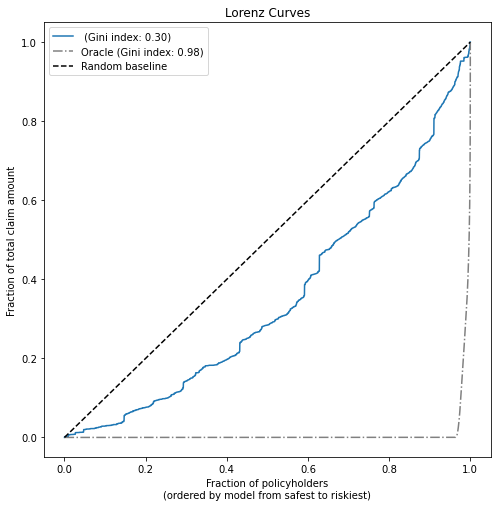

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
fig, ax = plt.subplots(figsize=(8, 8))

ordered_samples, cum_claims = lorenz_curve(df.ClaimAmount, df.prob)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = " (Gini index: {:.2f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

ordered_samples, cum_claims = lorenz_curve(df.ClaimAmount, df.ClaimAmount)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = "Oracle (Gini index: {:.2f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray",label=label)

ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel=('Fraction of policyholders\n'
            '(ordered by model from safest to riskiest)'),
    ylabel='Fraction of total claim amount'
)
ax.legend(loc="upper left")
plt.plot()
plt.show()

In [6]:
# Print confusion table
def confusion(y_true, y_pred):
    tab = pd.DataFrame(index=['True_1', 'True_0'], columns=['Pred_1', 'Pred_0', 'Total', 'Pct. Correct'])
    TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))
    TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    tab.loc['True_1', 'Pred_1'] = TP
    tab.loc['True_0', 'Pred_1'] = FP
    tab.loc['True_1', 'Pred_0'] = FN
    tab.loc['True_0', 'Pred_0'] = TN
    tab['Total'] = tab.sum(axis=1)
    P = tab.loc['True_1', 'Total']
    N = tab.loc['True_0', 'Total']
    tab.loc['True_1', 'Pct. Correct'] = TP / P # Sensitivity
    tab.loc['True_0', 'Pct. Correct'] = TN / N # Specificity 
    print('\nConfusion Table:')
    print(tab.to_string(formatters=['{:.0f}'.format, '{:.0f}'.format, '{:.0f}'.format, '{:.2f}'.format]))
    acc = (TP + TN) / tab['Total'].sum()
    bal = (TP/P + TN/N) / 2
    print('Accuracy: %1.4f' % acc)
    print('Balanced Accuracy: %1.4f' % bal)

In [7]:
y_pred = (df.prob > 0.50) * 1.0
y_true = (df.ClaimAmount > 0) * 1.0 
confusion(y_true, y_pred)


Confusion Table:
       Pred_1 Pred_0 Total Pct. Correct
True_1   1731    771  2502     0.691847
True_0  29299  36420 65719     0.554178
Accuracy: 0.5592
Balanced Accuracy: 0.6230
